# Credit Card Fraud Detection with Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import (classification_report, accuracy_score, 
                             confusion_matrix, precision_score, 
                             recall_score, f1_score, 
                             roc_auc_score, roc_curve)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, Sequential
import seaborn as sns
from pylab import rcParams


# Setting the random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Plotting configurations
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

# Labels for the classification
LABELS = ["Normal", "Fraud"]

# Only include this if running in a Jupyter Notebook
%matplotlib inline

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().values.any()

False

## Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

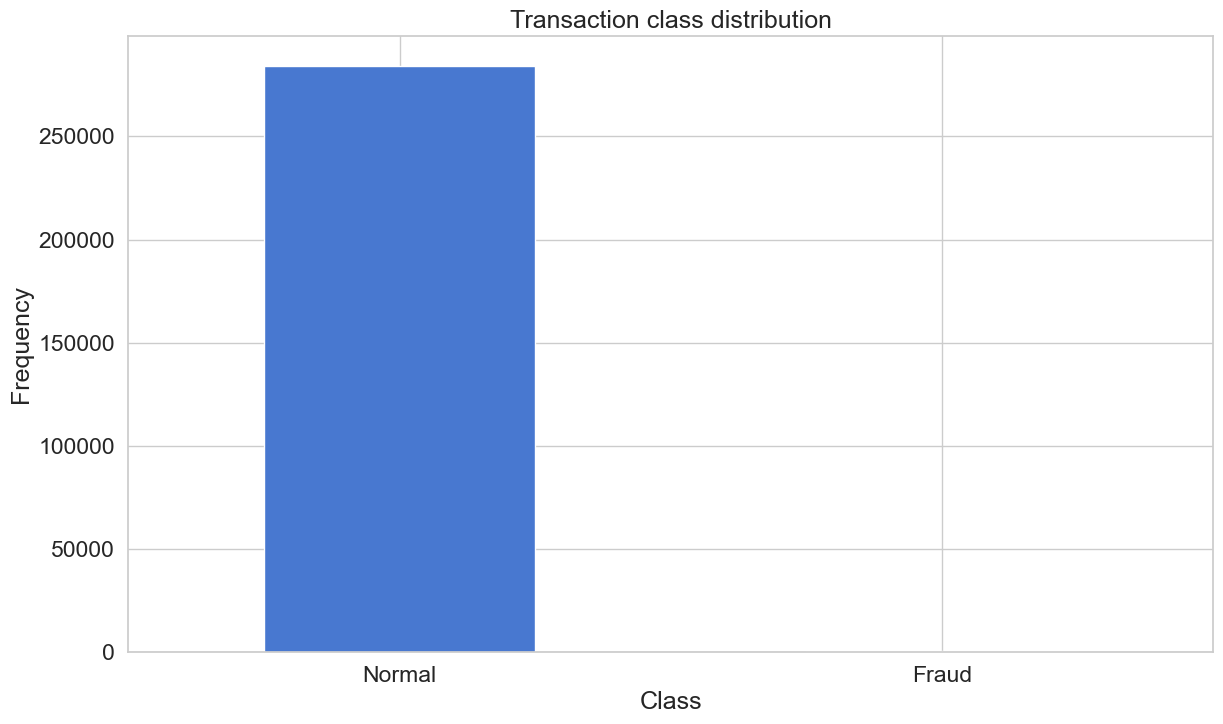

In [5]:
# Labels for the classification
LABELS = ["Normal", "Fraud"]

# Check if DataFrame and 'Class' column exist
if 'Class' in df.columns:
        count_classes = pd.value_counts(df['Class'], sort=True)
        count_classes.plot(kind='bar', rot=0)
        plt.title("Transaction class distribution")
        plt.xticks(range(len(LABELS)), LABELS)
        plt.xlabel("Class")
        plt.ylabel("Frequency")
        plt.show()
else:
        print("Error: 'Class' column not found in DataFrame.")

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [7]:
normal.shape

(284315, 31)

## Checking the amount of money involved in each kind of transaction

In [8]:
# Fraud transactions
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
# Non-fraud transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Graphical representation of Amount

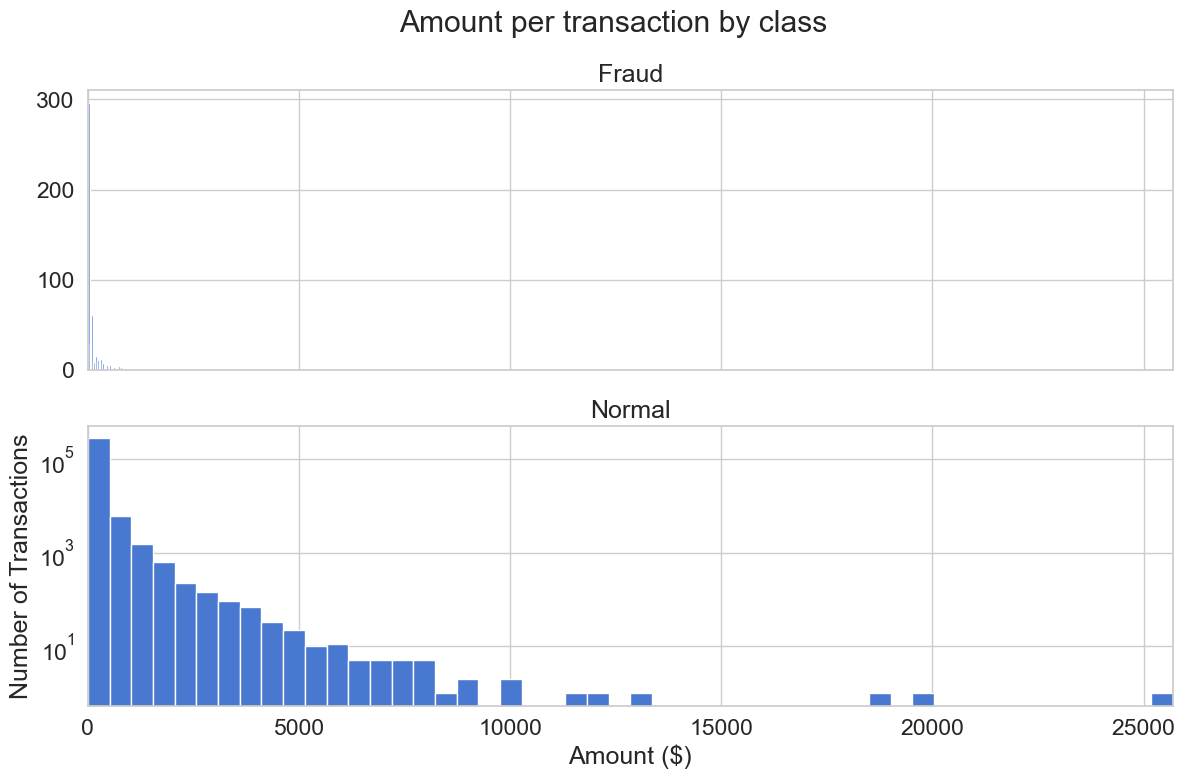

In [10]:
if 'Amount' in df.columns and 'Class' in df.columns:
    # Separate the data into fraudulent and normal transactions
    frauds = df[df['Class'] == 1]
    normal = df[df['Class'] == 0]

    # Create a figure with two subplots sharing the x-axis
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Amount per transaction by class')

    # Number of bins for the histogram
    bins = 50

    # Plot the histogram for fraudulent transactions on the first subplot
    ax1.hist(frauds.Amount, bins=bins)
    ax1.set_title('Fraud')

    # Plot the histogram for normal transactions on the second subplot
    ax2.hist(normal.Amount, bins=bins)
    ax2.set_title('Normal')

    # Set the x-axis label for the bottom subplot
    plt.xlabel('Amount ($)')
    plt.ylabel('Number of Transactions')

    # Dynamically set the x-axis limits based on the maximum transaction amount in the data
    max_amount = df['Amount'].max()
    plt.xlim((0, max_amount))

    # Set the y-axis to a logarithmic scale for better visualization of the data distribution
    plt.yscale('log')

    # Display the plots
    plt.show()
    
else:
    # Print an error message if the required columns are not found in the DataFrame
    print("Error: Required columns 'Amount' and 'Class' not found in DataFrame.")

## Plotting time of transaction to check for correlations

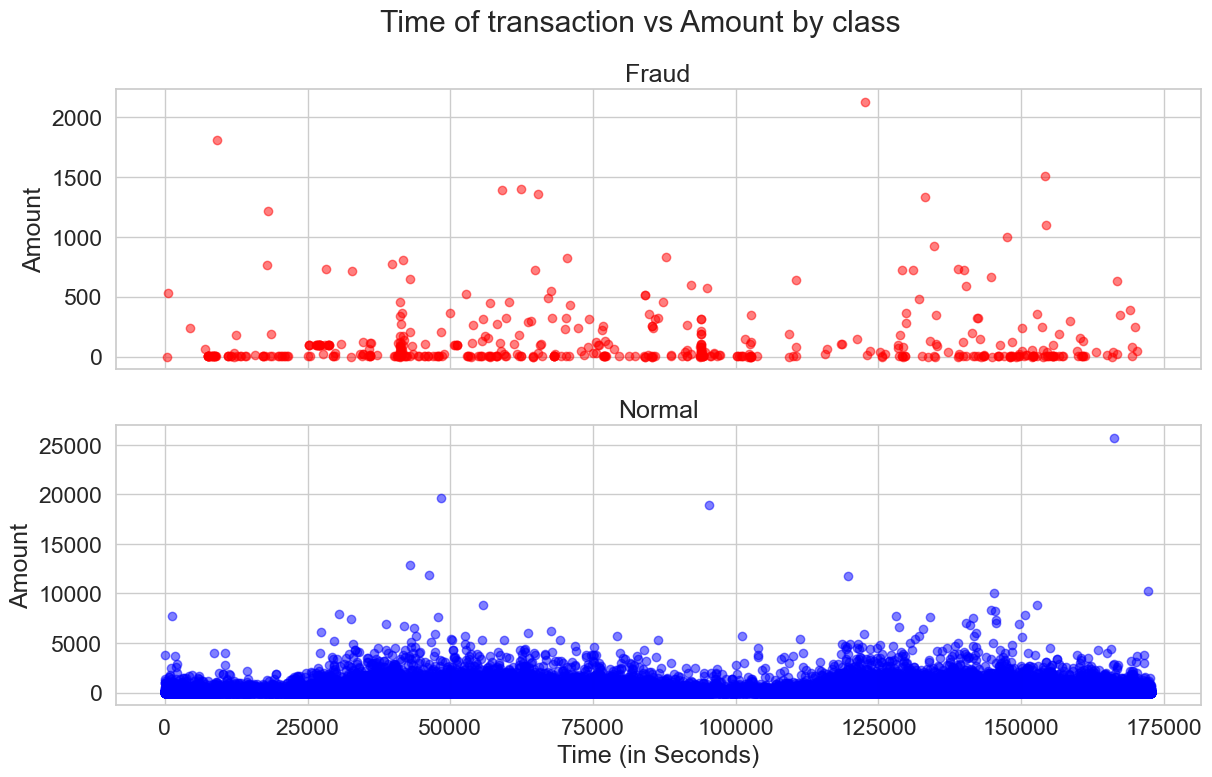

In [11]:
if 'Time' in df.columns and 'Amount' in df.columns and 'Class' in df.columns:
    
    # Separate the data into fraudulent and normal transactions
    frauds = df[df['Class'] == 1]
    normal = df[df['Class'] == 0]

    # Create a figure with two subplots sharing the x-axis
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Time of transaction vs Amount by class')

    # Plot a scatter plot for fraudulent transactions on the first subplot
    ax1.scatter(frauds.Time, frauds.Amount, c='red', alpha=0.5, label='Fraud')
    ax1.set_title('Fraud')
    ax1.set_ylabel('Amount')

    # Plot a scatter plot for normal transactions on the second subplot
    ax2.scatter(normal.Time, normal.Amount, c='blue', alpha=0.5, label='Normal')
    ax2.set_title('Normal')
    ax2.set_xlabel('Time (in Seconds)')
    ax2.set_ylabel('Amount')

    # Display the plots
    plt.show()
    
else:
    # Print an error message if the required columns are not found in the DataFrame
    print("Error: Required columns 'Time', 'Amount', and 'Class' not found in DataFrame.")

In [12]:
# Drop the 'Time' column from the DataFrame
data = df.drop(['Time'], axis=1)

## Scaling the Amount using StandardScaler

In [13]:
# Standardize the 'Amount' column
# The StandardScaler is used to scale the 'Amount' values to have a mean of 0 and a standard deviation of 1
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Building the model

In [14]:
# Separate the non-fraudulent transactions
non_fraud = data[data['Class'] == 0]

# Separate the fraudulent transactions
fraud = data[data['Class'] == 1]

# Concatenate the non-fraudulent and fraudulent transactions
# Shuffle the concatenated data to mix non-fraudulent and fraudulent transactions
df = pd.concat([non_fraud, fraud]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Separate the features (input variables) from the labels (target variable)
X = df.drop(['Class'], axis=1).values
Y = df['Class'].values

# Print a message indicating that data preparation was successful
print("Data preparation successful.")

Data preparation successful.


## Spiting the data into 80% training and 20% testing

In [15]:
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# Separating fraud and non-fraud transactions in the training set
train_non_fraud = train_data[train_data.Class == 0].drop(['Class'], axis=1)
train_fraud = train_data[train_data.Class == 1]

# Preparing test features and labels
X_test = test_data.drop(['Class'], axis=1)
y_test = test_data['Class']

# Converting to NumPy arrays if necessary (depending on downstream usage)
X_train_non_fraud = train_non_fraud.values
X_test = X_test.values

# Print shape of the training set for non-fraud transactions
print("Shape of X_train_non_fraud:", X_train_non_fraud.shape)

Shape of X_train_non_fraud: (227451, 29)


## Autoencoder model

In [16]:
# Input layer
input_layer = Input(shape=(X.shape[1],))

# Encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(1e-4))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# Decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# Output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Model summary
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 100)               3000      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 100)               5100      
                                                                 
 dense_4 (Dense)             (None, 29)                2929      
                                                                 
Total params: 18629 (72.77 KB)
Trainable params: 18629 (72.

## Training the credit card fraud detection model

In [17]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the non-fraudulent training data and transform it
X_train_non_fraud_scaled = scaler.fit_transform(X_train_non_fraud)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Determine the input dimensionality (number of features) from the scaled training data
input_dim = X_train_non_fraud_scaled.shape[1]

# Define the architecture of the autoencoder
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# Train the model
history = autoencoder.fit(X_train_non_fraud_scaled, X_train_non_fraud_scaled,
                          epochs=50,
                          batch_size=32,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/50

7108/7108 [==============================] - 29s 4ms/step - loss: 0.7579 - val_loss: 0.7454
Epoch 2/50
7108/7108 [==============================] - 27s 4ms/step - loss: 0.7112 - val_loss: 0.7360
Epoch 3/50
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7056 - val_loss: 0.7331
Epoch 4/50
7108/7108 [==============================] - 30s 4ms/step - loss: 0.7027 - val_loss: 0.7302
Epoch 5/50
7108/7108 [==============================] - 39s 6ms/step - loss: 0.7010 - val_loss: 0.7286
Epoch 6/50
7108/7108 [==============================] - 42s 6ms/step - loss: 0.6992 - val_loss: 0.7274
Epoch 7/50
7108/7108 [==============================] - 34s 5ms/step - loss: 0.6976 - val_loss: 0.7262
Epoch 8/50
7108/7108 [==============================] - 32s 5ms/step - loss: 0.6962 - val_loss: 0.7257
Epoch 9/50
7108/7108 [==============================] - 31s 4ms/step - loss: 0.6953 - val_loss: 0.7231
Epoch 10/50
7108/7108 [==============================] - 29s 4ms/step - 

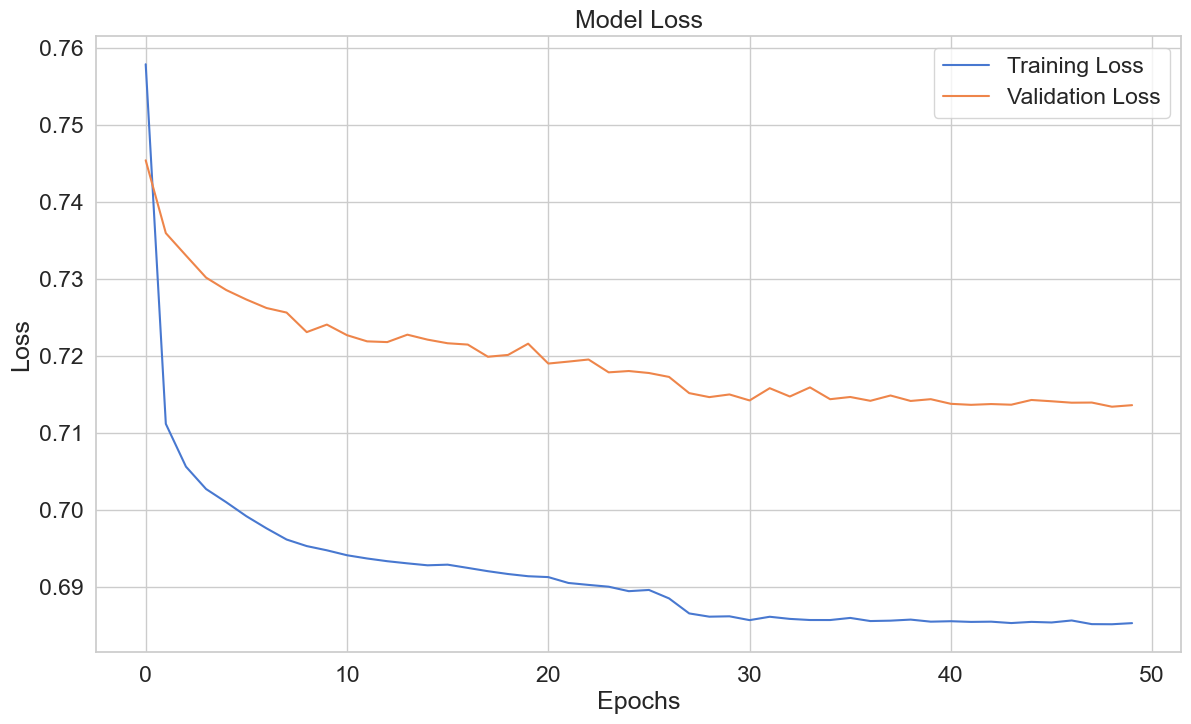

In [19]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Scaling the values

In [20]:
# Separate the features (input variables) from the target variable 'Class'
x = data.drop(["Class"], axis=1)
y = data["Class"].values

# Scale the feature values to the range [0, 1] using MinMaxScaler
x_scale = MinMaxScaler().fit_transform(x.values)

# Separate the scaled data into normal (non-fraudulent) and fraudulent transactions
x_norm = x_scale[y == 0]
x_fraud = x_scale[y == 1]

# Train the autoencoder using a subset of normal transactions
# The autoencoder is trained to reconstruct normal transactions
autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size=256, epochs=10,
                shuffle=True, validation_split=0.20)

Epoch 1/10
7/7 [==============================] - 1s 185ms/step - loss: 0.2392 - val_loss: 0.2138
Epoch 2/10
7/7 [==============================] - 0s 80ms/step - loss: 0.2062 - val_loss: 0.2029
Epoch 3/10
7/7 [==============================] - 0s 50ms/step - loss: 0.1981 - val_loss: 0.1971
Epoch 4/10
7/7 [==============================] - 0s 49ms/step - loss: 0.1957 - val_loss: 0.1940
Epoch 5/10
7/7 [==============================] - 0s 43ms/step - loss: 0.1910 - val_loss: 0.1874
Epoch 6/10
7/7 [==============================] - 0s 44ms/step - loss: 0.1882 - val_loss: 0.1880
Epoch 7/10
7/7 [==============================] - 0s 42ms/step - loss: 0.1820 - val_loss: 0.1794
Epoch 8/10
7/7 [==============================] - 0s 44ms/step - loss: 0.1791 - val_loss: 0.1771
Epoch 9/10
7/7 [==============================] - 0s 48ms/step - loss: 0.1767 - val_loss: 0.1762
Epoch 10/10
7/7 [==============================] - 0s 48ms/step - loss: 0.1758 - val_loss: 0.1747


# Obtain the Hidden Representation

In [21]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

## Model Prediction

In [22]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 6ms/step


## Getting the representation data

In [23]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

## Train, Test, Split

In [24]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

## Credit Card Fraud Detection Prediction model

In [25]:
# Train the logistic regression classifier
clf = LogisticRegression(solver="lbfgs", max_iter=1000).fit(train_x, train_y)

# Predict the validation set
pred_y = clf.predict(val_x)
pred_y_proba = clf.predict_proba(val_x)[:, 1]

# Print classification report
print("\nClassification Report:\n", classification_report(val_y, pred_y))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       748
         1.0       0.97      0.78      0.86       125

    accuracy                           0.96       873
   macro avg       0.97      0.89      0.92       873
weighted avg       0.96      0.96      0.96       873



In [26]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(val_y, pred_y)
precision = precision_score(val_y, pred_y)
recall = recall_score(val_y, pred_y)
f1 = f1_score(val_y, pred_y)
roc_auc = roc_auc_score(val_y, pred_y_proba)

print("\nEvaluation Metrics:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("ROC AUC Score: ", roc_auc)


Evaluation Metrics:
Accuracy:  0.9644902634593356
Precision:  0.97
Recall:  0.776
F1 Score:  0.8622222222222222
ROC AUC Score:  0.9633262032085561


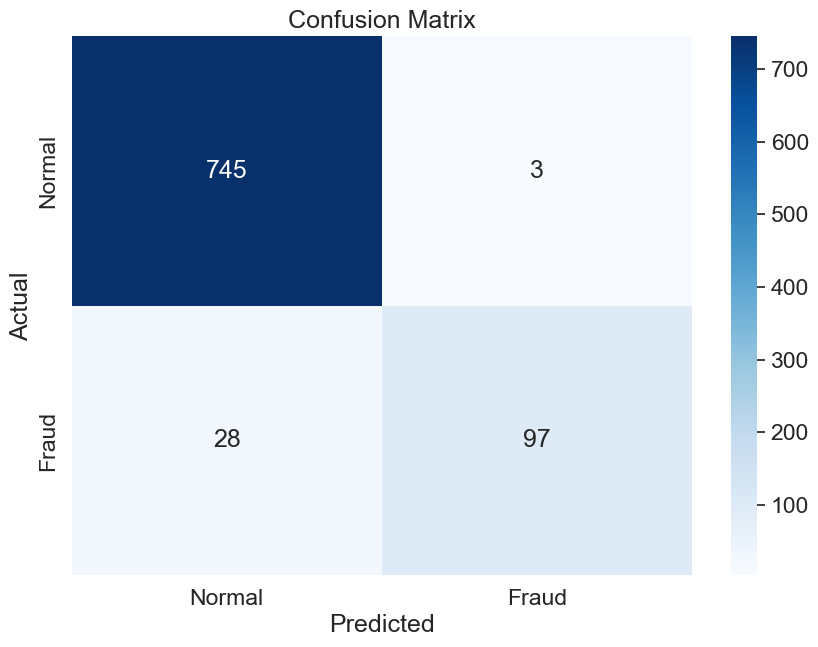

In [27]:
# Plot confusion matrix
conf_matrix = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

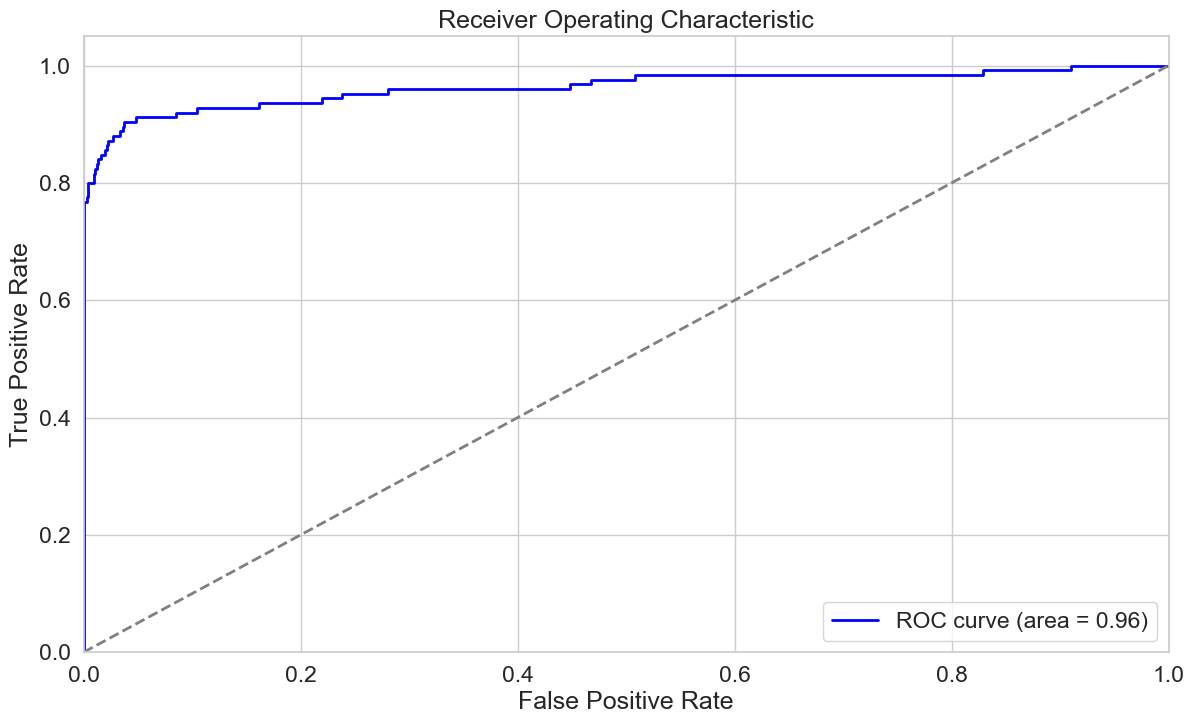

In [28]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(val_y, pred_y_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()